In [19]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import FancyBboxPatch
import matplotlib.ticker as mtick
import math

In [20]:
# multiplies the inner radius for easier viewing
inner_radius_modify = 1.3
inner_text_radius = 1.1

# colors

palette = 'orangeblue'
if palette == "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette == "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

if palette == 'blue':
    small_palette = [
        'mediumaquamarine',
        'royalblue',
        'mediumpurple'
    ]
elif palette == 'orangeblue':
    small_palette = [
        '#006373',
        '#E8891D',
        '#219ebc',
#         '#05A3A4',
        #'#EA652C'
    ]

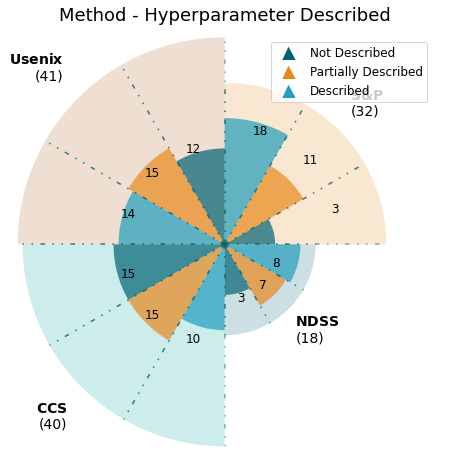

In [21]:
###### FIGURE 2 #######


### Polar Coordinate ###
df = pd.read_csv("sheet1_2023_only.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}

df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]

df = df[~df['Hyperparameters'].isna()]
df['Hyperparameters'] = df['Hyperparameters'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette == "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette == "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only

def convert_label(x):
    if x == -1:
        return 0
    return x
df_temp = df.copy()
df_temp["Hyperparameters"] = df_temp["Hyperparameters"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Hyperparameters"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique())
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2

small_colors = np.tile(small_palette,4)

# Scale small boxes so we can see them
ave = 35#np.mean(small_radi)

small_radi_mod = [s if s > ave else s + 0.2*ave for s in small_radi ]
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge')

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]),
            verticalalignment=alignments[c][0],
            horizontalalignment=alignments[c][1],
            fontsize=14
           )

## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='Not Described',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Partially Described',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Described',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Method - Hyperparameter Described",
    fontsize=18
)

plt.savefig("Figure2_23_hyper.pdf",bbox_inches='tight')








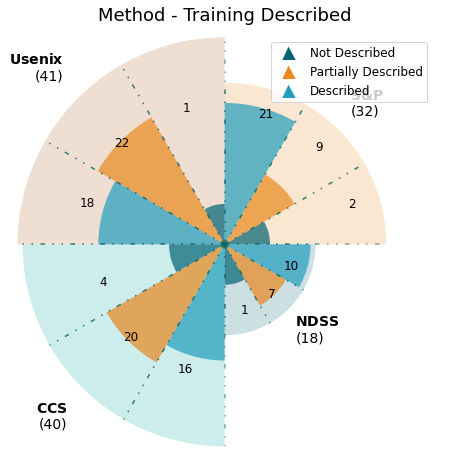

In [22]:
######## FIGURE 3 #########


### Polar Coordinate ###
df = pd.read_csv("sheet1_2023_only.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}

df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]

df = df[~df['Training Described'].isna()]
df['Training Described'] = df['Training Described'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette == "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette == "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only

def convert_label(x):
    if x == -1:
        return 0
    return x
df_temp = df.copy()
df_temp["Training Described"] = df_temp["Training Described"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Training Described"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique())
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2

small_colors = np.tile(small_palette,4)

# Scale small boxes so we can see them
ave = 35#np.mean(small_radi)

small_radi_mod = [s if s > ave else s + 0.2*ave for s in small_radi ]
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge')

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]),
            verticalalignment=alignments[c][0],
            horizontalalignment=alignments[c][1],
            fontsize=14
           )

## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='Not Described',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Partially Described',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Described',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Method - Training Described",
    fontsize=18
)

plt.savefig("Figure3_23_train.pdf",bbox_inches='tight')







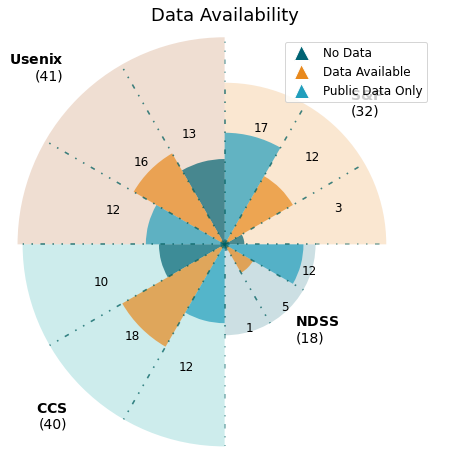

In [23]:
###### FIGURE 4 ########


### Polar Coordinate ###
df = pd.read_csv("sheet1_2023_only.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}

df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]

df = df[~df.Data_Available.isna()]
df['Data_Available'] = df['Data_Available'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette == "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette == "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only

def convert_label(x):
    if x == -1:
        return 0
    elif x == 0:
        return 0
    elif x == 4:
        return 2
    elif x>0 & x<4:
        return 1
    elif x == 8:
        return 0
    elif x>4 & x <8:
        return 1
    else:
        return 2
df_temp = df.copy()
df_temp["Data_Available"] = df_temp["Data_Available"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Data_Available"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique())
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2


small_colors = np.tile(small_palette,4)
# Scale small boxes so we can see them

small_radi_mod = 1.3*(small_radi)
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge')

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]),
            verticalalignment=alignments[c][0],
            horizontalalignment=alignments[c][1],
            fontsize=14
           )

## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='No Data',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Data Available',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Public Data Only',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Data Availability",
    fontsize=18
)

plt.savefig("Figure4_23_data.pdf",bbox_inches='tight')






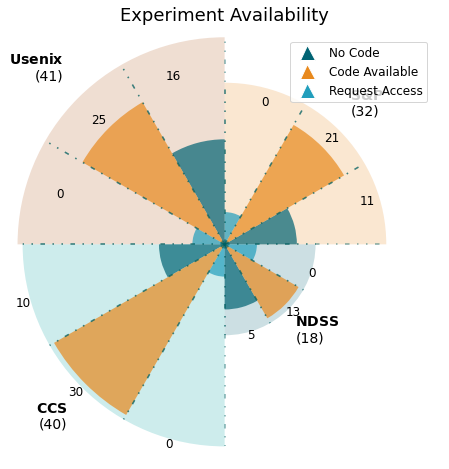

In [24]:
######### FIGURE 5 #########


### Polar Coordinate ###
df = pd.read_csv("sheet1_2023_only.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}

df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]
df = df[~df.Available.isna()]
df['Available'] = df['Available'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")


conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices


# we will shrink the codes into 0 - no code, 1 - code there, 2 - available in future but never posted,
# 3 - request access
# For now just going off 0 and 1


def convert_label(x):
    if x == -1:
        return 0
    elif x > 2 and x < 7:
        return 1
    elif x == 2:
        return 0
    elif x == 8:
        return 0
    elif x == 7:
        return 2
    else:
        return x
df_temp = df.copy()
df_temp["Available"] = df_temp["Available"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Available"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique())
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]*inner_radius_modify
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2


small_colors = np.tile(small_palette,4)
# Scale small boxes so we can see them
ave = np.mean(small_radi)

small_radi_mod = [s if s > 0.5*ave else s + 0.45*ave for s in small_radi ]
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge')

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]),
            verticalalignment=alignments[c][0],
            horizontalalignment=alignments[c][1],
            fontsize=14
           )

## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r/inner_radius_modify),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r),
               verticalalignment=alignments[c][0],
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='No Code',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Code Available',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Request Access',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Experiment Availability",
    fontsize=18
)

plt.savefig("Figure5_23_code.pdf",bbox_inches='tight')


